In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve,confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import chi2_contingency

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
titanic = pd.read_csv("/Users/hitulshah/DataUniverse/Titanic/train.csv")

In [4]:
titanic.shape

(891, 12)

In [5]:
titanic.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


(array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 10 Patch objects>)

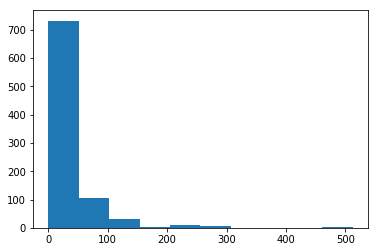

In [6]:
plt.hist(titanic.Fare)

In [7]:
titanic[titanic.Fare > 150].groupby('Survived').describe().loc[:,'Fare']

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,9.0,210.098611,46.774916,151.55,153.4625,221.7792,247.52080,263.0000
1,20.0,254.580215,118.143439,151.55,164.8667,227.5250,262.53125,512.3292


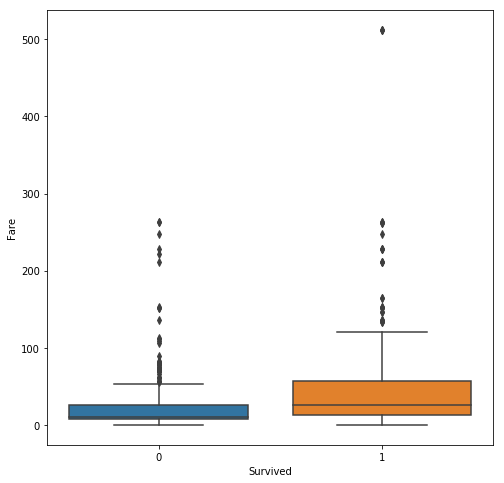

In [8]:
fig , ax = plt.subplots(figsize=(8,8))
sns.boxplot('Survived', 'Fare',data = titanic)
plt.show()

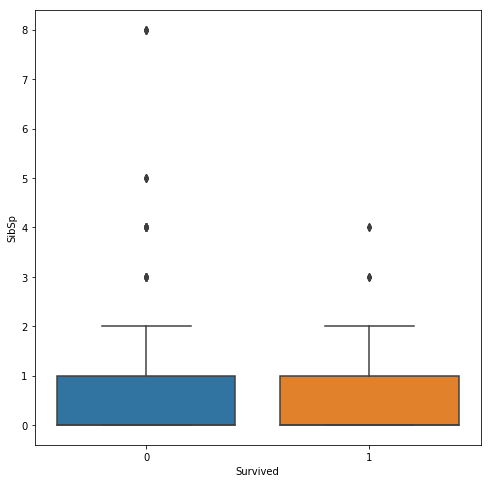

In [9]:
fig , ax = plt.subplots(figsize=(8,8))
sns.boxplot('Survived', 'SibSp',data = titanic)
plt.show()

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
LR = LogisticRegression()
LR.fit(np.array(titanic.Fare).reshape(-1,1), np.array(titanic.Survived))
LR.coef_

array([[0.01506685]])

Missing values

In [12]:
titanic.groupby('Survived').describe().loc[:, 'Age']

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


In [13]:
titanic.groupby('Survived').mean().loc[:,'Fare'].values

array([22.11788689, 48.3954076 ])

In [14]:
#dc['Age'] = titanic.groupby('Survived').mean().loc[:,'Fare'].values
#pd.isnull(titanic.loc[5,'Age'])
#titanic[['Age','Survived']].apply(lambda x: dc['Age'][int(x[1])] if pd.isnull(x[0]) else x[0], axis = 1)

In [15]:
from sklearn.preprocessing import MaxAbsScaler, Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from category_encoders import OneHotEncoder,OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

In [16]:
class DataSelector (BaseEstimator , TransformerMixin):
    def __init__ (self,Features):
        self.Features = Features
    def fit(self, X , y = None):
        return self 
    def transform(self, X, y = None):
        return X[self.Features]

In [17]:
num_vars = ['Age', 'SibSp', 'Parch','Fare']
num_pipe = Pipeline([
                    ('Selector', DataSelector(num_vars))
                    ,('imp', Imputer(strategy= 'median'))
                    ,('scale', MaxAbsScaler())
                    ])

In [18]:
class CategoricalImputer(BaseEstimator , TransformerMixin):
    def __init__ (self):
        self
    def fit(self, X, y = None):
        self.fillValues_ = dict([(i , X[i].value_counts().index[0]) for i in X])
        return self 
    def transform(self, X, y = None):
        return X.fillna(value = self.fillValues_)

In [19]:
cat_vars = ['Sex', 'Embarked'] 
cat_pipe = Pipeline([
                    ('Selector', DataSelector(cat_vars))
                    ,('CategoricalImputer', CategoricalImputer())
                    ,('OneHotEncoder', OneHotEncoder(drop_invariant= True , use_cat_names= True))
                    ])

In [20]:
class OrdinalImputer(BaseEstimator , TransformerMixin):
    def __init__ (self):
        self
    def fit(self, X, y = None):
        self.fillValues_ = dict([(i , X[i].value_counts().index[0]) for i in X])
        return self 
    def transform(self, X, y = None):
        return X.fillna(value = self.fillValues_)

In [21]:
Ord_vars = ['Pclass'] 
Ord_pipe = Pipeline([
                    ('Selector', DataSelector(Ord_vars))
                    ,('OrdinalImputer', OrdinalImputer())
                    ,('OrdinalEncoder', OrdinalEncoder(drop_invariant= True))
                    ])

In [22]:
full_pipeline = FeatureUnion(transformer_list= [
                            ('num_pipe', num_pipe)
                            ,('cat_pipe', cat_pipe)
                            ,('Ord_pipe', Ord_pipe)
                            
                                ])

In [23]:
features = full_pipeline.fit_transform(titanic)
target = titanic['Survived']

In [24]:
index = np.random.randint(0, target.shape[0], target.shape[0])
features = features[index]
target = target[index]

In [25]:
RF = RandomForestClassifier(random_state= 42,n_estimators= 30)

In [26]:
model_RF = RF.fit(features, target)

In [27]:
train_score = cross_val_score(RF, features, target, cv = 3)

In [28]:
target_pred = cross_val_predict(RF, features, target, cv = 3, method = 'predict_proba')[:, 1]

In [29]:
precision, recall ,thresholds = precision_recall_curve(target, target_pred)

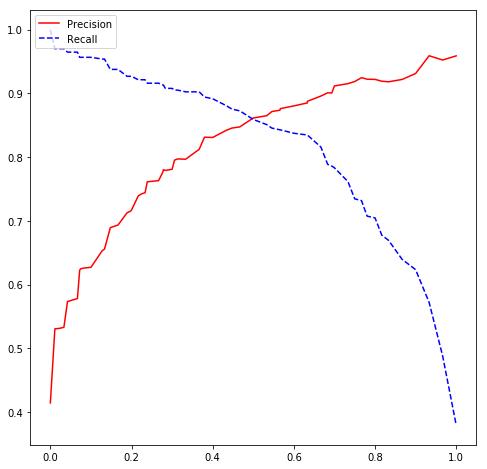

In [30]:
fig , ax = plt.subplots(figsize=(8,8))
plt.plot(thresholds, precision[:-1], 'r-', label = 'Precision')
plt.plot(thresholds, recall[:-1], 'b--', label = 'Recall')
plt.legend(loc = 'upper left')

In [31]:
print(classification_report(target, cross_val_predict(RF, features, target, cv = 3)))

             precision    recall  f1-score   support

          0       0.90      0.91      0.90       522
          1       0.87      0.85      0.86       369

avg / total       0.88      0.88      0.88       891



In [32]:
fpr, tpr , thresholds = roc_curve(target, target_pred)

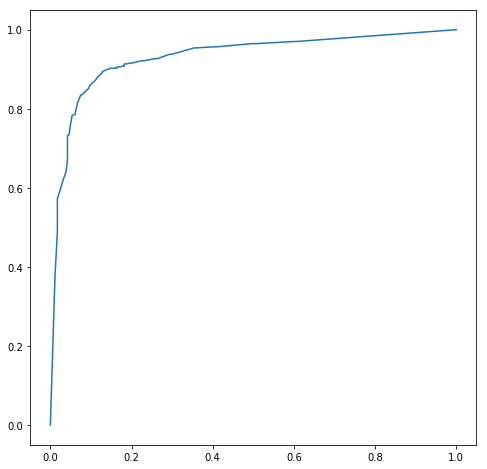

In [33]:
fig , ax = plt.subplots(figsize=(8,8))
plt.plot(fpr, tpr, label = 'ROC')

In [34]:
print(classification_report(target, target_pred > 0.4 ))

             precision    recall  f1-score   support

          0       0.91      0.88      0.90       522
          1       0.84      0.88      0.86       369

avg / total       0.88      0.88      0.88       891



In [51]:
parameters = {'n_estimators': [10,20,30], 'criterion' : ['gini', 'entropy'], 'max_features': ['auto', 'sqrt'] ,'max_leaf_nodes':[10,12,15], 'max_depth':[5,7,10]}

In [52]:
grid_search =  GridSearchCV(RF, param_grid= parameters , cv = 3)

In [53]:
grid_search.fit(features, target)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt'], 'max_leaf_nodes': [10, 12, 15], 'max_depth': [5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': 15,
 'n_estimators': 30}

In [55]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=15,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [40]:
grid_search.best_score_

0.8900112233445566

In [57]:
RF = RandomForestClassifier(random_state= 42,n_estimators= 30,max_depth= 10,criterion= 'gini',max_features= 'auto', max_leaf_nodes= 15)

In [58]:
model_RF = RF.fit(features, target)

In [59]:
TEST = pd.read_csv('/Users/hitulshah/DataUniverse/Titanic/test.csv')

In [60]:
TAR_TEST_PRED = model_RF.predict(full_pipeline.transform(TEST))

In [61]:
TAR_TEST_PRED

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [62]:
pd.concat([pd.DataFrame(TEST.PassengerId),pd.DataFrame(TAR_TEST_PRED, columns= ['Survived'])], axis = 1).to_csv('titanic_submission_1.csv')